# Review Text Attributes Models

## Import libraries and files

This notebook builds a range of machine learning models based upon the text characteristics within the review itself.

* Section 1 - Import libraries and dataset
* Section 2 - Pre-processing and feature engineering
* Section 3 - Models

Datasets needed to run the notebook:

* Text_attributes.csv


# Section 1: Import libaries and data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import string
import re
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest,chi2,RFECV,VarianceThreshold
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RepeatedStratifiedKFold,cross_val_score,learning_curve
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score, balanced_accuracy_score
from sklearn.metrics import auc,roc_auc_score,roc_curve,precision_recall_curve,plot_precision_recall_curve
from sklearn.metrics import precision_score,recall_score,f1_score,fbeta_score,f1_score

import warnings
warnings.filterwarnings("ignore")

In [95]:
df = pd.read_csv("Text_attributes.csv",index_col = 0)
df.head(2)

,Category,Name,Title,Review,Rating,Town,all_text,num_words,num_chars,av_word_len,uppercase,prop_uc,special_chars,prop_sc,Emoji,Emoji_count,Emoji_prop
0,Accommodation,Butlins,"Nice break, shame about the accommodation...",We booked our 3 night stay from 27-30 December...,4,Bognor,"Nice break, shame about the accommodation... W...",1057,4823,4.562914,46,0.009538,152,0.031516,0,0,0.0
1,Accommodation,Butlins,Horrendous noise Oyster Bay,In Oyster Bay. Oh dear.\n\nVery poor sound ins...,1,Bognor,Horrendous noise Oyster Bay In Oyster Bay. Oh ...,214,1066,4.981308,32,0.030019,39,0.036585,0,0,0.0


In [96]:
df.shape

(10407, 17)

# Section 2: Data Pre-processing and Feature Engineering

## Set ratings to binary

In [97]:
# Create new column for Score and set binary values for ratings
df["Score"] = df["Rating"]
df = df[df["Rating"] != 3]
df.Score.replace([1,2], 1, inplace = True)
df.Score.replace([4,5], 0, inplace = True)
df.drop(columns = ["Rating"],axis = 1, inplace = True)

In [98]:
df= df.drop(columns = ["Name","Title","Review","all_text","Town","Emoji","uppercase","special_chars","Emoji_count"],axis = 1)

In [99]:
df.head(2)

,Category,num_words,num_chars,av_word_len,prop_uc,prop_sc,Emoji_prop,Score
0,Accommodation,1057,4823,4.562914,0.009538,0.031516,0.0,0
1,Accommodation,214,1066,4.981308,0.030019,0.036585,0.0,1


In [100]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9530 entries, 0 to 10406
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Category     9530 non-null   object 
 1   num_words    9530 non-null   int64  
 2   num_chars    9530 non-null   int64  
 3   av_word_len  9530 non-null   float64
 4   prop_uc      9530 non-null   float64
 5   prop_sc      9530 non-null   float64
 6   Emoji_prop   9530 non-null   float64
 7   Score        9530 non-null   int64  
dtypes: float64(4), int64(3), object(1)
memory usage: 670.1+ KB


## Heatmap

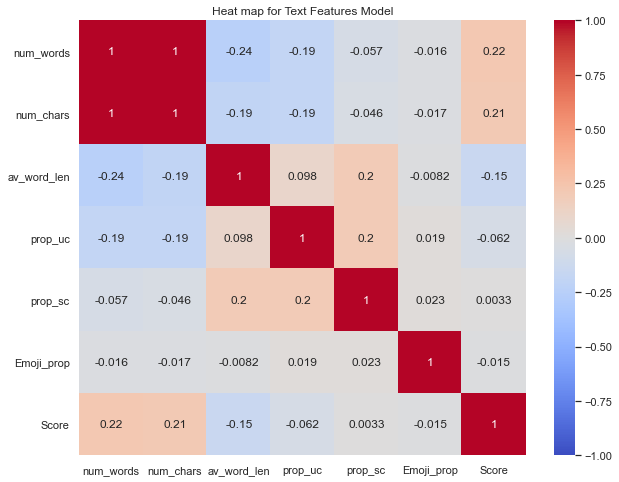

In [101]:
# Heatmap to show relationships
cor_mat = df.corr()
plt.figure(figsize=(10,8))
plt.title("Heat map for Text Features Model")
#plot heat map
g=sns.heatmap(cor_mat,annot=True,vmin=-1, cmap='coolwarm')

The number of words and characters have multicollinearity.

## Get sample dataset

In [113]:
# Drop number of characters as the correlation is slightly higher with the number of words and there is multicollinearity
df.drop(columns = ["num_chars"],axis = 1,inplace = True)

In [114]:
# Function to get balanced sample based on ratings for each dataframe
def sampling(df,sample_size):
    sampled_good = df[df["Score"] == 0].sample(sample_size)
    sampled_bad = df[df["Score"] == 1]
    new_df = sampled_good.append(sampled_bad)
    new_df = new_df.sample(frac=1).reset_index(drop=True)
    return new_df

In [115]:
df_balanced = sampling(df,df.Score.value_counts()[1])
df_balanced["Score"].value_counts()

0    1301
1    1301
Name: Score, dtype: int64

In [116]:
# Define X and y variables
X = df_balanced.drop(["Score","Category"], axis = 1)
y = df_balanced["Score"]

## Train, test, split

In [117]:
# Function to split each balanced dataframe into training, validation and test splits with a stratified rating value
def splitting(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X,y, stratify = y,test_size=0.2, random_state=1)
    X_test, X_val, y_test, y_val = train_test_split(X_test, y_test,stratify = y_test, test_size=0.50, random_state=1)     
    return X_train,y_train,X_val,y_val,X_test,y_test

In [118]:
# Run function
X_train,y_train,X_val,y_val,X_test,y_test = splitting(X,y)
print(X_train.shape,y_train.shape,X_val.shape,y_val.shape,X_test.shape,y_test.shape)

(2081, 5) (2081,) (261, 5) (261,) (260, 5) (260,)


In [119]:
# Values of Scores - check balanced
y_train.value_counts()

0    1041
1    1040
Name: Score, dtype: int64

In [120]:
# Check statistics to see if means and standard deviations vary so scaling is appropriate
X_train.describe()

,num_words,av_word_len,prop_uc,prop_sc,Emoji_prop
count,2081.000000,2081.000000,2081.000000,2081.000000,2081.000000
mean,107.930322,4.564227,0.028946,0.027380,0.000174
std,110.922497,0.419939,0.020358,0.012814,0.002136
min,16.000000,3.428571,0.000000,0.000000,0.000000
25%,46.000000,4.286885,0.019324,0.019380,0.000000
50%,76.000000,4.500000,0.025346,0.025974,0.000000
75%,131.000000,4.765217,0.034286,0.033175,0.000000
max,1792.000000,6.771429,0.404396,0.129450,0.066667


In [121]:
X_train.head()

,num_words,av_word_len,prop_uc,prop_sc,Emoji_prop
1385,185,4.351351,0.038509,0.040994,0.0
806,56,4.375000,0.024490,0.004082,0.0
106,68,4.808824,0.030581,0.021407,0.0
2307,47,4.340426,0.024510,0.024510,0.0
2053,75,3.880000,0.048110,0.017182,0.0


## Scaling

In [122]:
# Scale data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.fit_transform(X_val)

In [123]:
X_train

,num_words,av_word_len,prop_uc,prop_sc,Emoji_prop
1385,185,4.351351,0.038509,0.040994,0.0
806,56,4.375000,0.024490,0.004082,0.0
106,68,4.808824,0.030581,0.021407,0.0
2307,47,4.340426,0.024510,0.024510,0.0
2053,75,3.880000,0.048110,0.017182,0.0
...,...,...,...,...,...
136,75,4.720000,0.036723,0.025424,0.0
453,61,4.459016,0.033088,0.044118,0.0
1545,28,4.214286,0.033898,0.033898,0.0
1864,37,3.891892,0.013889,0.027778,0.0


## Feature Selection

In [124]:
# Recursive Feature Elimination using cross validation
def recurse(m,X,y):
    rfecv = RFECV(estimator = m, step = 1, scoring = "accuracy")
    rfecv.fit(X,y)
    rfecv.transform(X)
    return rfecv

In [125]:
result_lr = recurse(LogisticRegression(),X_train,y_train)
print(result_lr.n_features_)

5


In [126]:
print(result_lr.support_)
print(result_lr.grid_scores_)
print(result_lr.ranking_)

[ True  True  True  True  True]
[0.601636   0.60163715 0.604041   0.63764066 0.66312143]
[1 1 1 1 1]


In [127]:
X_train.columns

Index(['num_words', 'av_word_len', 'prop_uc', 'prop_sc', 'Emoji_prop'], dtype='object')

# Section 3: Training Models

In [128]:
# Function to train with specified model on the training set
def train_accuracy(model):
    kf = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3)
    scores = cross_val_score(model, X_train,y_train ,cv = kf, scoring = "accuracy", n_jobs =-1)
    return scores.mean()

In [129]:
print(X_train.shape,X_val.shape,y_train.shape,y_val.shape)

(2081, 5) (261, 5) (2081,) (261,)


## Dummy Classifer and Baseline ML Models

In [130]:
# Set models with defaut parameters
dummy_model = DummyClassifier(strategy = 'uniform')
nb = MultinomialNB()
lr = LogisticRegression()
rf = RandomForestClassifier()
svm = SVC(probability = True, kernel = 'rbf')

In [131]:
# Train models
dum_train = train_accuracy(dummy_model)
nb_train = train_accuracy(nb)
log_train = train_accuracy(lr)
rf_train = train_accuracy(rf)
svm_train = train_accuracy(svm)

In [132]:
train_summary = pd.DataFrame({"Dummy":[dum_train],"Naive Bayes":[nb_train],"LogReg":[log_train],"Random Forest": [rf_train],
                              "SVM":[svm_train]})
train_summary

,Dummy,Naive Bayes,LogReg,Random Forest,SVM
0,0.495928,0.655112,0.663291,0.645529,0.650342


## Predicting with each Model

In [133]:
# Create function to run diagnostic reports and graphs

def run_mod(model,X,y):
    
    # Fit model on training set and predict on test set
    model_name = str(model)
    model.fit(X,y)
    y_pred = model.predict(X_val)
        
    # Classification Report
    print(classification_report(y_val, y_pred))
    
    # Learning Curve    
    train_sizes, train_scores, val_scores = learning_curve(model,X,y, scoring = "accuracy",
                                                            n_jobs =-1,train_sizes = np.linspace(0.01,1.0,50))
    train_mean = np.mean(train_scores, axis = 1)
    train_std = np.std(train_scores, axis = 1)
    val_mean = np.mean(val_scores, axis = 1)
    val_std = np.mean(val_scores, axis = 1)
    
    plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
    plt.plot(train_sizes, val_mean, color="#111111", label="Cross-validation score")
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
    plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, color="#DDDDDD")

    plt.title("Learning Curve")
    plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
    plt.tight_layout()
    plt.show()
    
    # ROC Curve and AUC score
    target_probs = model.predict_proba(X_val)[:,1]
    false_positive_rate, true_positive_rate, threshold = roc_curve(y_val, target_probs)
    plt.title('Receiver Operating Characteristic')
    plt.plot(false_positive_rate, true_positive_rate)
    plt.plot([0, 1], ls="--")
    plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    
    # Precision-Recall Curve 
    precision, recall, thresholds = precision_recall_curve(y_val,target_probs)
    no_skill = len(y_val[y_val==1]) / len(y_val)
    plt.plot(recall, precision, marker='.')
    plt.plot([0, 1], [no_skill,no_skill], linestyle='--', label='No Skill Model')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.show()
    
    # histogram of predicted probabilities of the positive
    plt.hist(target_probs)
    plt.xlim(0,1)
    plt.title('Histogram of predicted probabilities')
    plt.xlabel('Predicted probability of Bad Review')
    plt.ylabel('Frequency')
       
    # Metrics
    accuracy = accuracy_score(y_val, y_pred)
    balanced_accuracy = balanced_accuracy_score(y_val,y_pred)
    rocauc = roc_auc_score(y_val,target_probs)
    auc_score = auc(recall,precision)
    precision = precision_score(y_val, y_pred, average='binary')
    recall = recall_score(y_val, y_pred, average='binary')
    f1 = f1_score(y_val, y_pred, average='binary')
    f2_score = fbeta_score(y_val, y_pred, beta =2.0, labels=None, pos_label=1)
       
    
    run_mod.results = pd.DataFrame({"Accuracy":accuracy, "Balanced_acc":balanced_accuracy,
                                    "Precision":precision, "Recall":recall,
                                    "F1":f1,"F2":f2_score,"ROCAUC":rocauc,"PRAUC":auc_score}, index = [0]
                                  )
 
     
    # y_pred is an array of predictions
    best_thresh = None
    best_score = 0
    for thresh in np.arange(0.1, 0.501, 0.01):
        score = f1_score(y_val, y_pred>thresh)
        if score > best_score:
            best_thresh = thresh
            best_score = score
    print("Best F1 score:",best_score , "Best threshold value:",best_thresh)
                
    # Confusion Matrix
    fig, ax = plt.subplots()
    cf_matrix = confusion_matrix(y_val, y_pred)
    sns.heatmap(cf_matrix, annot = True, fmt = "d",)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title("Confusion Matrix", fontsize = 15)
    _ = ax.xaxis.set_ticklabels(['Good Reviews','Bad Reviews'],fontsize = 8)
    _ = ax.yaxis.set_ticklabels(['Good Reviews', 'Bad Reviews'], fontsize = 8)
    

              precision    recall  f1-score   support

           0       0.59      0.77      0.67       130
           1       0.67      0.47      0.55       131

    accuracy                           0.62       261
   macro avg       0.63      0.62      0.61       261
weighted avg       0.63      0.62      0.61       261



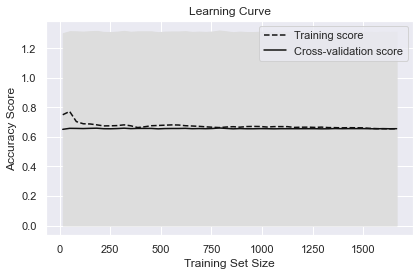

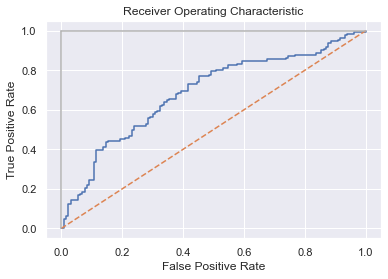

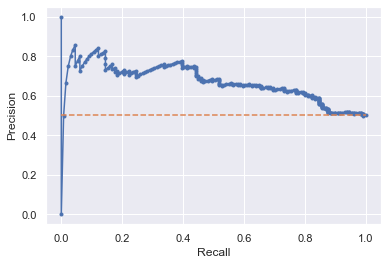

Best F1 score: 0.5495495495495495 Best threshold value: 0.1


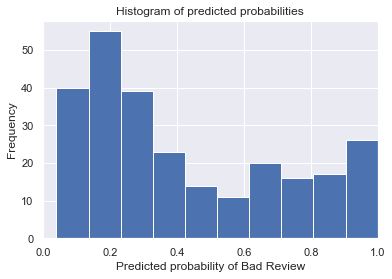

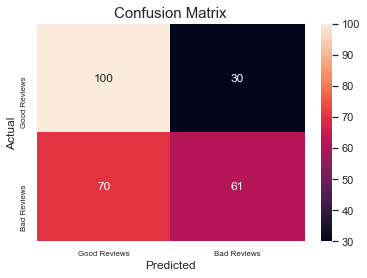

In [134]:
run_mod(nb,X_train,y_train)

In [135]:
nb_base = run_mod.results
nb_base

,Accuracy,Balanced_acc,Precision,Recall,F1,F2,ROCAUC,PRAUC
0,0.616858,0.61744,0.67033,0.465649,0.54955,0.495935,0.685555,0.668901


              precision    recall  f1-score   support

           0       0.59      0.64      0.61       130
           1       0.61      0.56      0.59       131

    accuracy                           0.60       261
   macro avg       0.60      0.60      0.60       261
weighted avg       0.60      0.60      0.60       261



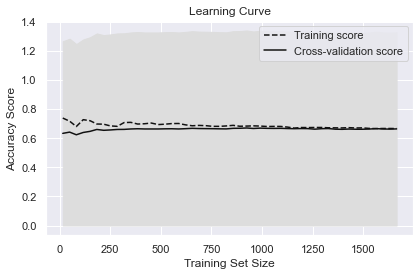

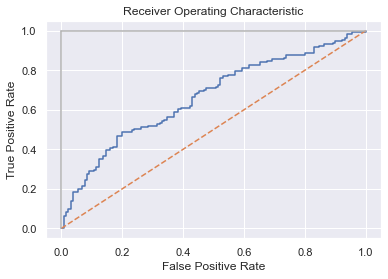

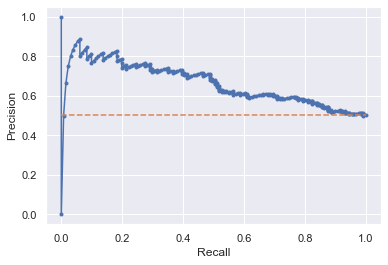

Best F1 score: 0.5873015873015873 Best threshold value: 0.1


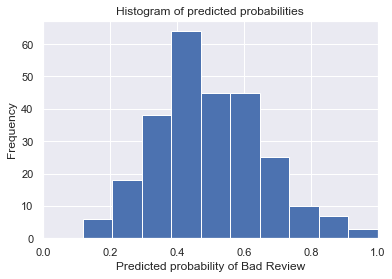

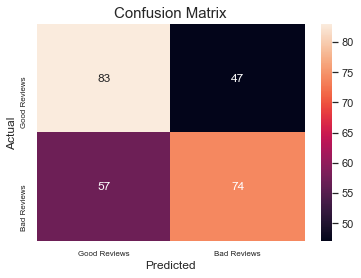

In [136]:
run_mod(lr,X_train,y_train)

In [137]:
lr_base = run_mod.results
lr_base

,Accuracy,Balanced_acc,Precision,Recall,F1,F2,ROCAUC,PRAUC
0,0.601533,0.601674,0.61157,0.564885,0.587302,0.573643,0.663594,0.661164


              precision    recall  f1-score   support

           0       0.66      0.67      0.66       130
           1       0.67      0.66      0.66       131

    accuracy                           0.66       261
   macro avg       0.66      0.66      0.66       261
weighted avg       0.66      0.66      0.66       261



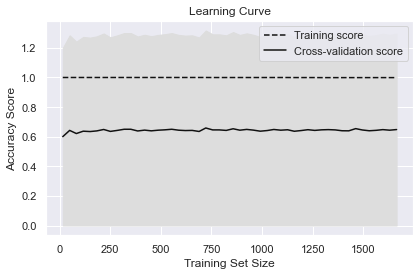

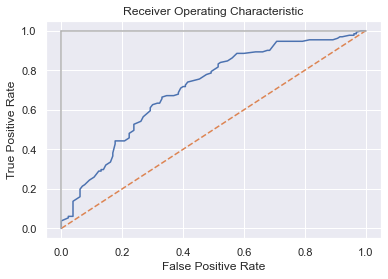

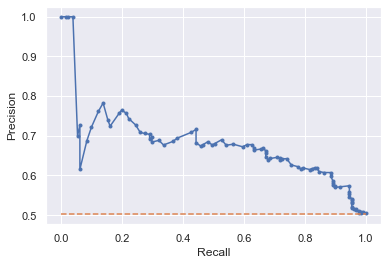

Best F1 score: 0.6615384615384616 Best threshold value: 0.1


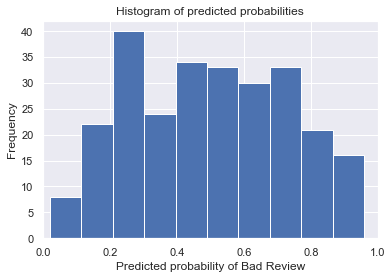

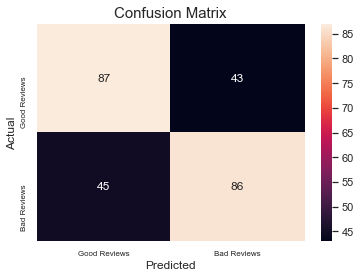

In [138]:
run_mod(rf,X_train,y_train)

In [139]:
rf_base = run_mod.results
rf_base

,Accuracy,Balanced_acc,Precision,Recall,F1,F2,ROCAUC,PRAUC
0,0.662835,0.66286,0.666667,0.656489,0.661538,0.658499,0.706371,0.680607


              precision    recall  f1-score   support

           0       0.60      0.77      0.67       130
           1       0.68      0.49      0.57       131

    accuracy                           0.63       261
   macro avg       0.64      0.63      0.62       261
weighted avg       0.64      0.63      0.62       261



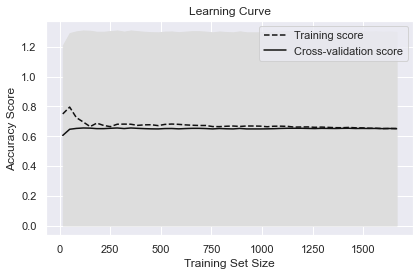

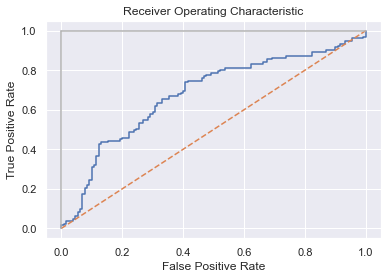

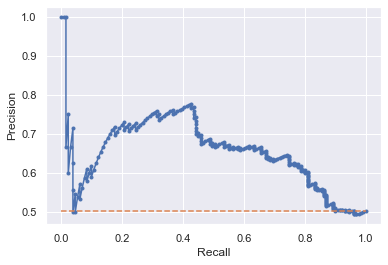

Best F1 score: 0.5688888888888889 Best threshold value: 0.1


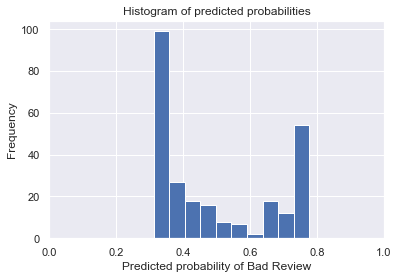

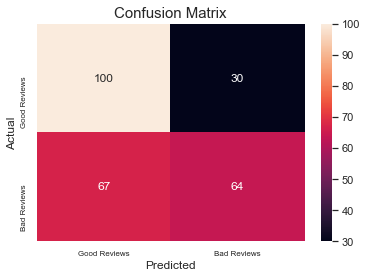

In [140]:
run_mod(svm,X_train,y_train)

In [141]:
svm_base = run_mod.results
svm_base

,Accuracy,Balanced_acc,Precision,Recall,F1,F2,ROCAUC,PRAUC
0,0.628352,0.62889,0.680851,0.48855,0.568889,0.517799,0.677686,0.653477


In [142]:
models = ["Multinomial NB","Logistic Regression","Random Forest","Support Vector"]

training_summary = pd.concat([nb_base,lr_base,rf_base,svm_base])
training_summary.set_index([models],inplace = True)
training_summary

,Accuracy,Balanced_acc,Precision,Recall,F1,F2,ROCAUC,PRAUC
Multinomial NB,0.616858,0.617440,0.670330,0.465649,0.549550,0.495935,0.685555,0.668901
Logistic Regression,0.601533,0.601674,0.611570,0.564885,0.587302,0.573643,0.663594,0.661164
Random Forest,0.662835,0.662860,0.666667,0.656489,0.661538,0.658499,0.706371,0.680607
Support Vector,0.628352,0.628890,0.680851,0.488550,0.568889,0.517799,0.677686,0.653477
